In [7]:
import csv
import json
import time
import numpy as np
import pandas as pd
import regex as re
import requests
import urllib
import random
import seaborn as sns
import evaluate
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import GPT2Tokenizer
from transformers import AutoModelForSequenceClassification
from transformers import GPT2ForSequenceClassification
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import pipeline
from transformers import AutoTokenizer
from datasets import *
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import gc
gc.collect()
torch.cuda.empty_cache()

In [13]:
################################ DATASET CLEANING AND T/T/V SPLIT ################################

# Read and clean data
df = pd.read_csv("BG3_reviews_updated.csv")

df['target'] = df['voted_up'].astype(int)
clean_df = df[['review', 'target']]
clean_df.columns = ['sentence', 'label']

# Remove rows where 'sentence' is empty or does not contain any alphabetic characters
clean_df = clean_df.dropna(subset=['sentence'])
clean_df = clean_df[clean_df['sentence'].str.contains('[a-zA-Z]', regex=True)]
clean_df['sentence'] = clean_df['sentence'].apply(lambda x: x[:512])

# Remove duplicate rows
clean_df = clean_df.drop_duplicates()

pos_counts = clean_df['label'].value_counts()
print("COMPLETE_CLEANED")
print(pos_counts)

#Undersample Positive reviews
clean_df = clean_df.groupby('label').apply(lambda x: x.sample(n=min(30000, len(x))))
pos_counts = clean_df['label'].value_counts()
print("COMPLETE_UNDERSAMPLED")
print(pos_counts)


# Split the data into train, test, and validation sets
train_df, temp_df = train_test_split(clean_df, test_size=0.3, stratify=clean_df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

pos_counts = train_df['label'].value_counts()
print("TRAIN_BEFORE")
print(pos_counts)


# Perform oversampling on the training set
pos_train = train_df[train_df['label'] == 1]
neg_train = train_df[train_df['label'] == 0]

# Oversample the negative reviews
neg_train_oversampled = neg_train.sample(n=len(pos_train), replace=True, random_state=42)

# Combine the positive and oversampled negative reviews
train_df_balanced = shuffle(pd.concat([pos_train, neg_train_oversampled]))

pos_counts = train_df_balanced['label'].value_counts()
print("TRAIN_AFTER")
print(pos_counts)

pos_counts = valid_df['label'].value_counts()
print("VALID")
print(pos_counts)

pos_counts = valid_df['label'].value_counts()
print("TEST")
print(pos_counts)


# Save the balanced training set and the original test and validation sets to csv
train_df_balanced.to_csv('train_data_balanced.csv', index=False)
valid_df.to_csv('valid_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)


COMPLETE_CLEANED
label
1    243947
0     10008
Name: count, dtype: int64
COMPLETE_UNDERSAMPLED
label
1    30000
0    10008
Name: count, dtype: int64
TRAIN_BEFORE
label
1    21000
0     7005
Name: count, dtype: int64
TRAIN_AFTER
label
1    21000
0    21000
Name: count, dtype: int64
VALID
label
1    4500
0    1501
Name: count, dtype: int64
TEST
label
1    4500
0    1501
Name: count, dtype: int64


C:\Users\wills\AppData\Local\Temp\ipykernel_6768\2474264754.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_df = clean_df.groupby('label').apply(lambda x: x.sample(n=min(30000, len(x))))


In [14]:
################################ TOKENIZE DATA FOR GPT ################################

# Load datasets using the datasets library
train_dataset = load_dataset('csv', data_files='train_data_balanced.csv')['train']
valid_dataset = load_dataset('csv', data_files='valid_data.csv')['train']
test_dataset = load_dataset('csv', data_files='test_data.csv')['train']


# Create a DatasetDict
split = DatasetDict({
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
})

# Tokenize data for GPT
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(batch):
    return tokenizer(batch['sentence'], padding="max_length", truncation=True)

tokenized_dataset = split.map(tokenize_fn, batched=True)

# Set Format
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

C:\Users\wills\Dis\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/42000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6001 [00:00<?, ? examples/s]

Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

In [15]:
################################ GPT MODEL TRAINING ################################

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)

training_args = TrainingArguments(
    output_dir='gpt_3_epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1_score': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.398000,0.624577,0.894184,0.868647
2,0.211000,0.516375,0.921680,0.896385
3,0.170400,0.564601,0.922513,0.897151


TrainOutput(global_step=126000, training_loss=0.3639501202901204, metrics={'train_runtime': 33493.7642, 'train_samples_per_second': 3.762, 'train_steps_per_second': 3.762, 'total_flos': 6.5846781149184e+16, 'train_loss': 0.3639501202901204, 'epoch': 3.0})

//////////////////
Great game, obviously pretty buggy but its in early access. Can't wait for the finished product #%#%#%#%##%#%#%#%#   has been classified as  0 and should be  1
//////////////////
//////////////////
TOO addictive...I am consumed by the women. My life is in ruins. All my friends and family are worried. They called the cops asking for a welfare check assuming I had died. I am too busy fawning over Lae'zel to maintain myself. #%#%#%#%##%#%#%#%#   has been classified as  1 and should be  0
//////////////////
//////////////////
I have really enjoyed this game. Anyone who plays DnD or has played before should play this game I can not recommend this enough. #%#%#%#%##%#%#%#%#   has been classified as  0 and should be  1
//////////////////
//////////////////
Boner alert #%#%#%#%##%#%#%#%#   has been classified as  0 and should be  1
//////////////////
//////////////////
Overall, BG3 was a good experience, and I enjoyed the time I've played thus far.  There are some minor bugs

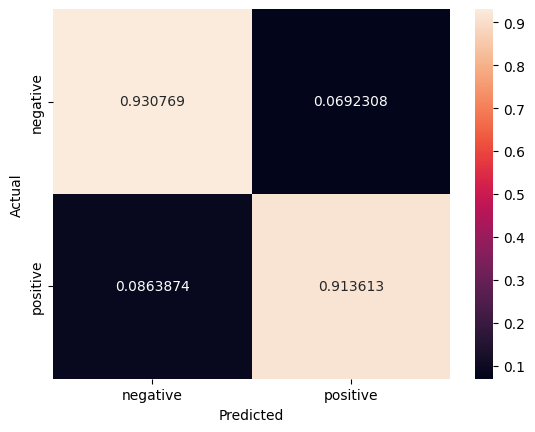

In [16]:
################################ GPT MODEL TESTING ################################

saved_model = pipeline('text-classification',
                       model = 'gpt_3_epoch/checkpoint-126000')
def plot_cm(cm):
  classes = ['negative','positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
    
predictions = saved_model(split['test']['sentence'][:512])

def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

failed_inputs = []

for input, prediction, label in zip(split['test']['sentence'][:512], predictions, split['test']['label']):
  if prediction != label:
    print('//////////////////')
    print(input, '#%#%#%#%##%#%#%#%#   has been classified as ', prediction, 'and should be ', label)
    print('//////////////////')
    failed_inputs.append(input)

def classify_string_length(input_string):
    if len(input_string) <= 175:
        return "small"
    elif len(input_string) <= 350:
        return "medium"
    else:
        return "large"

def count_classifications(classifications):
    counts = {
        "small": classifications.count("small"),
        "medium": classifications.count("medium"),
        "large": classifications.count("large")
    }
    return counts

# Classify each string
classifications = [classify_string_length(s) for s in failed_inputs]

# Count each classification
counts = count_classifications(classifications)

# Print the counts
print(f"Small: {counts['small']}")
print(f"Medium: {counts['medium']}")
print(f"Large: {counts['large']}")

print("accuracy:",accuracy_score(split['test']['label'][:512], predictions))
print("f1:",f1_score(split['test']['label'][:512], predictions, average = 'macro'))
cm = confusion_matrix(split['test']['label'][:512],predictions, normalize = 'true')
plot_cm(cm)

In [3]:
################################ TOKENIZE DATA FOR BERT ################################

# Load datasets using the datasets library
train_dataset = load_dataset('csv', data_files='train_data_balanced.csv')['train']
valid_dataset = load_dataset('csv', data_files='valid_data.csv')['train']
test_dataset = load_dataset('csv', data_files='test_data.csv')['train']


# Create a DatasetDict
split = DatasetDict({
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
})

# Tokenize data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_fn(batch):
    return tokenizer(batch['sentence'], padding="max_length", truncation=True)

tokenized_dataset = split.map(tokenize_fn, batched=True)

# Set Format
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

C:\Users\wills\Dis\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
################################ BERT MODEL TRAINING ################################

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='bert_3_epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=2e-5
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1_score': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\wills\Dis\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.298600,0.346029,0.938010,0.916968
2,0.105900,0.399361,0.941176,0.922599
3,0.016500,0.516270,0.941843,0.921227


TrainOutput(global_step=63000, training_loss=0.16241358408482656, metrics={'train_runtime': 12626.7907, 'train_samples_per_second': 9.979, 'train_steps_per_second': 4.989, 'total_flos': 3.315199297536e+16, 'train_loss': 0.16241358408482656, 'epoch': 3.0})

//////////////////
If you like challenge over story, the game goes from a 10/10 to a 7/10 to a 3/10 (Yes really, 3/10).

Endgame is almost like a visual novel; Fights are trivial and the same battle strat works for all of them. If you have played DOS2, the fight staging is much less sophisticated. 

Think World of Warcraft raid type staging: There is an obvious best place to put your ranged characters (they all have teleport, don't worry), best place to choke the fight, etc etc. AI in later acts doesn't do much, and this is a #%#%#%#%##%#%#%#%#   has been classified as  0 and should be  1
//////////////////
//////////////////
This game makes blizzard look terrible. cost £10 less, is graphically stunning and has excellent voice acting all the way through. #%#%#%#%##%#%#%#%#   has been classified as  0 and should be  1
//////////////////
//////////////////
There's one part where there are cultists of an evil death god, but they are not technically hostile to the party. I killed them anyw

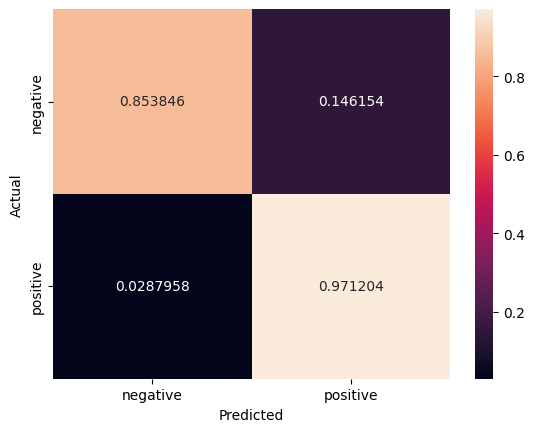

In [10]:
################################ BERT MODEL TESTING ################################

saved_model = pipeline('text-classification',
                       model = 'bert_3_epoch/checkpoint-63000')
def plot_cm(cm):
  classes = ['negative','positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
    
predictions = saved_model(split['test']['sentence'][:512])

def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

failed_inputs = []

for input, prediction, label in zip(split['test']['sentence'][:512], predictions, split['test']['label']):
  if prediction != label:
    print('//////////////////')
    print(input, '#%#%#%#%##%#%#%#%#   has been classified as ', prediction, 'and should be ', label)
    print('//////////////////')
    failed_inputs.append(input)

def classify_string_length(input_string):
    if len(input_string) <= 175:
        return "small"
    elif len(input_string) <= 350:
        return "medium"
    else:
        return "large"

def count_classifications(classifications):
    counts = {
        "small": classifications.count("small"),
        "medium": classifications.count("medium"),
        "large": classifications.count("large")
    }
    return counts

# Classify each string
classifications = [classify_string_length(s) for s in failed_inputs]

# Count each classification
counts = count_classifications(classifications)

# Print the counts
print(f"Small: {counts['small']}")
print(f"Medium: {counts['medium']}")
print(f"Large: {counts['large']}")
  
print("accuracy:",accuracy_score(split['test']['label'][:512], predictions))
print("f1:",f1_score(split['test']['label'][:512], predictions, average = 'macro'))
cm = confusion_matrix(split['test']['label'][:512],predictions, normalize = 'true')
plot_cm(cm)